## **State Schema**

when we define a LangGraph StateGraph, we use a state schema.

The state schema represents the structure and types of data that our grpah will use.

All Nodes are expected to comunicate with that schema.

LangGraph offers flexibility in how you define your state schema, accommodating various Python types and validation approaches

### **TypedDict**

is a dictionary subclass from Python´s libray that allows you to specify keys and their corresponding value types.

Note that these are type hints.

They can be used by static type checkers (like mypy) and IDES to catch potential type-related erros before the code is run,

But they are not enforced at runtime!

In [2]:
from typing import TypedDict

class TypedDictState(TypedDict):
    foo: str
    bar: str

For more specific value constraints , you can use things like Literal type hint

In [3]:
from typing import Literal

class TypedDictState(TypedDict):
    name: str
    mood: Literal["happy", "sad"]

We can use TypedDIctSate as our state in LangGraph by simpy passing it to StateGraph

We can think about every state key just as a channel in our graph, which we overwrite in each node

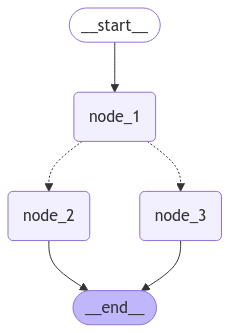

In [8]:
import random
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END

def node_1(state):
    print("----node_1----")
    return {"name": state['name'] + " is ...."}

def node_2(state):
    print("----node_2------")
    return {"mood": "happy"}

def node_3(state):
    print("----node_3------")
    return {"mood": "sad"}

def decide_mood(state) ->Literal["node_2", "node_3"]:

    if random.random() < 0.5:
        return "node_2"
    return "node_3"

builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
graph.invoke({"name": "javier"})

----node_1----
----node_2------


{'name': 'javier is ....', 'mood': 'happy'}

### **Pydantic**

With TypedDict and dataclasses they don´t enforce types at runtime. we could set mood to mad even though our type hint specifies mood: list[Literal["happy", "sad"]]

Pydantic can perform validaction to check whether data conforms to the specified types and constraints at runtime

In [12]:
from pydantic import BaseModel, validator, ValidationError

class PydatincState(BaseModel):
    name: str
    mood: Literal["happy", "sad"]

    @validator('mood')
    def validate_mood(cls, value):
        #Ensure the mood is either "happy" or "sad"
        if value not in ["happy", "sad"]:
            raise ValidationError("Each mood must be either 'happy' or 'sad")
        
try:
    state = PydatincState(name='John', mood='mad')
except ValidationError as e:
    print("Validation Error:", e) 

Validation Error: 1 validation error for PydatincState
mood
  Input should be 'happy' or 'sad' [type=literal_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/literal_error


C:\Users\jarai\AppData\Local\Temp\ipykernel_13884\1236348873.py:7: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.9/migration/
  @validator('mood')


## **State Reducers**

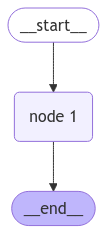

In [14]:
class State(TypedDict):
    foo: int

def node_1(state):
    print('-----Node 1------')
    return {'foo': state['foo'] + 1}

builder = StateGraph(State)
builder.add_node('node 1', node_1)

builder.add_edge(START, 'node 1')
builder.add_edge('node 1',END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

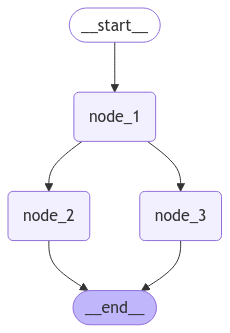

In [17]:
def node_1(state):
    print('-----Node 1------')
    return {'foo': state['foo'] + 1}

def node_2(state):
    print('-----Node 2------')
    return {'foo': state['foo'] + 1}

def node_3(state):
    print('-----Node 3------')
    return {'foo': state['foo'] + 1}


builder = StateGraph(State)
builder.add_node('node_1', node_1)
builder.add_node('node_2', node_2)
builder.add_node('node_3', node_3)

builder.add_edge(START, 'node_1')
builder.add_edge('node_1','node_2')
builder.add_edge('node_1', 'node_3')
builder.add_edge('node_2', END)
builder.add_edge('node_3', END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({'foo': 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError ocurred: {e}")

-----Node 1------
-----Node 2------
-----Node 3------
InvalidUpdateError ocurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


Reducers give us a general way to address this problem.

they specify how to perform updates.

We can use the Annotated type to specify a reducer function.

For example, in this case let´s append the value returned from each node rather than overwriting them.

We just need a reducer that can perform this: operator.add is a function from Python´s built-in operator module.

When operator.add is applied to lists, it performs list concatenation

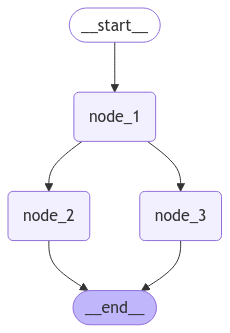

In [32]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print('-----Node 1------')
    return {'foo': [state['foo'][-1] + 1]}

def node_2(state):
    print('-----Node 2------')
    return {'foo': [state['foo'][-1] + 1]}

def node_3(state):
    print('-----Node 3------')
    return {'foo': [state['foo'][1] + 1]}

builder = StateGraph(State)
builder.add_node('node_1', node_1)
builder.add_node('node_2', node_2)
builder.add_node('node_3', node_3)

builder.add_edge(START, 'node_1')
builder.add_edge('node_1','node_2')
builder.add_edge('node_1', 'node_3')
builder.add_edge('node_2', END)
builder.add_edge('node_3', END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [33]:
from langgraph.errors import InvalidUpdateError
try:
    result = graph.invoke({'foo':[1]})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError ocurred: {e}")

result

-----Node 1------
-----Node 2------
-----Node 3------


{'foo': [1, 2, 3, 3]}

### **Custom Reducers**

In [34]:
def reduce_list(left:list | None , right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.
    
    Args:
        left (list | None): The first list to combine, or None
        right (list | None):  The second list to combine or None"""
    
    if not left:
        left = []
    if not right:
        right = []
    
    return left + right

class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

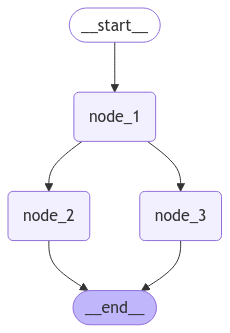

In [39]:
def node_1(state):
    print('-----Node 1------')
    return {'foo': [2]}

def node_2(state):
    print('-----Node 2------')
    return {'foo': [state['foo'][-1] + 1]}

def node_3(state):
    print('-----Node 3------')
    return {'foo': [state['foo'][-1] + 1]}

builder = StateGraph(CustomReducerState)
builder.add_node('node_1', node_1)
builder.add_node('node_2', node_2)
builder.add_node('node_3', node_3)

builder.add_edge(START, 'node_1')
builder.add_edge('node_1','node_2')
builder.add_edge('node_1', 'node_3')
builder.add_edge('node_2', END)
builder.add_edge('node_3', END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
graph.invoke({'foo': None})

-----Node 1------
-----Node 2------
-----Node 3------


{'foo': [2, 3, 3]}

## **Multiple Schemas**

There are cases we may want a bit more control over the schema:

* Internal nodes may pass information that is not required in the graph´s input / output
* We may also want to use different input / output schemas for the graph. The output might, for example, only contain as single relevant output key

### **Private State**

This is useful for anything needed as part of the intermediate working logic of the graph, but not relevant for the overall graph input or output.

We´ll define an OverallState and a PrivateState

node_2 uses PrivateState as input, but writes out to OverallState

In [42]:
class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    baz: int

def node_1(state: OverallState) -> PrivateState:
    print('------Node 1--------')
    return {'baz': state['foo'] + 1}


def node_2(state: PrivateState) -> OverallState:
    print('------Node 2-------')
    return {'foo': state['baz'] + 1}

#Build graph
builder = StateGraph(OverallState)
builder.add_node("node 1", node_1)
builder.add_node("node 2", node_2)

#Add edges
builder.add_edge(START, "node 1")
builder.add_edge("node 1", "node 2")
builder.add_edge("node 2", END)

graph = builder.compile()

graph.invoke({'foo': 1})

------Node 1--------
------Node 2-------


{'foo': 3}

### **Input/Output Schema**

Now, let´s use specific input / output schema with our graph.

In addition, we can use a type hint state: InputState to specify the input schema of each of our nodes

we use tpye hints below to, for example show that the output of answer_node will be filtered to OutputState
 

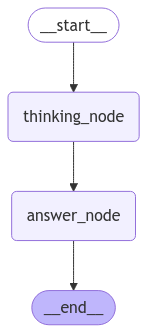

In [45]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: InputState):
    return {"answer": "bye", "notes": "... his name is  Lnace"}

def answer_node(state: OverallState) -> OutputState:
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState, input=InputState, output=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [47]:
graph.invoke({"question": "hi"})

{'answer': 'bye Lance'}

## **Filtering and Trimming messages**

### **Messages as state**

First, let´s define some messages.

In [48]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"SO you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about Whales, But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

SO you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about Whales, But what others should I learn about?


In [49]:
import os
from dotenv import load_dotenv, find_dotenv
from langchain_openai import ChatOpenAI

_ = load_dotenv(find_dotenv())
openai_api_key = os.environ['OPENAI_API_KEY']

llm = ChatOpenAI(model="gpt-3.5-turbo")

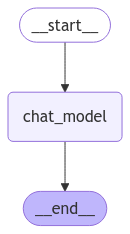

In [50]:
from langgraph.graph import MessagesState

#Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

#Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [51]:
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

SO you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about Whales, But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals worth learning about. Here are a few examples:

1. Dolphins: Dolphins are highly intelligent and social marine mammals known for their playful behavior and acrobatic skills. They belong to the cetacean family, which also includes whales and porpoises.

2. Seals and Sea Lions: Seals and sea lions are pinnipeds, which are semi-aquatic marine mammals with flippers for limbs. They are found in various regions around the world and are known for their agility in the water.

3. Manatees: Manatees, also known as sea cows, are large, herbivorous mari

### **Reducers**

A practical challenge when working with messages is managing long-running conversations.

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using RemoveMessage and add_messages reducer.

In [55]:
from langchain_core.messages import RemoveMessage

#Nodes
def filter_messages(state: MessagesState):
    #Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    # The add_messages reducer (in MessageState) recoginzes the RemoveMessagesa and removes them
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()



In [56]:
# Message list with a preamble
messages = [AIMessage("hi", name="Bot", id="1")]
messages.append(HumanMessage("hi!", name="Lance", id="2"))
messages.append(AIMessage("SO you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about Whales, But what others should I learn about?", name="Lance", id="4"))

output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

SO you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about Whales, But what others should I learn about?
================================== Ai Message ==================================

There are many fascinating ocean mammals beyond whales that you could research. Some examples include dolphins, seals, sea lions, manatees, otters, walruses, and polar bears. Each of these species has unique characteristics and behaviors that make them interesting to study.


## **Trim Messages**

Another approach is to trim messagesm based upon a set number of tokens.

This restricts the message history to a specified number of tokens.

While filtering only return a post-hoc subset of the msessages between agents, trimming restrict the number of tokens that a chat model can use to respond.



In [59]:
from langchain_core.messages import trim_messages

#Node
def chat_model_node(state: MessagesState):
    messages= trim_messages(
        state["messages"],
        max_tokens=100,
        strategy="last",
        token_counter=ChatOpenAI(model='gpt-3.5-turbo'),
        allow_partial=True
    )
    return {"messages": [llm.invoke(messages)]}

builder = StateGraph(MessagesState)
builder.add_node("chat model", chat_model_node)
builder.add_edge(START, "chat model")
builder.add_edge("chat model", END)

graph = builder.compile()



## **Chatbot with message Summarization**

In [60]:
llm = ChatOpenAI(model="gpt-3.5-turbo")

class State(MessagesState):
    summary: str

We will define a node to call our LLM that incorporates a summary, if exists into the prompt

In [61]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

def call_model(state: State):

    # Get summary if exists
    summary = state.get("summary", "")

    if summary:
        system_message = f"Here is a summary of conversation earlier: {summary}"

        #Append summary to newer messages
        messages = [SystemMessage(content=system_message)] + state['messages']
    else:
        messages = state['messages']
    
    response = llm.invoke(messages)
    return {"messages": response}

Define a node to produce a summary

In [80]:
def summarize_conversation(state: State):

    summary = state.get("summary","")
    if summary:
            summary_message = (f"This is a summary of thew conversation to date: {summary} \n"
                              " Extend the summary by taking into account the new messages above:")
    else:
          summary_message = "Create a summary of the conversation above:"
    
    messages = state['messages'] + [summary_message]
    response = llm.invoke(messages)

    # Delete all but the 2 most recent messages

    delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]
    return {"summary": response, "messages": delete_messages}



In [81]:
#Determine wether to end or summarize the conversation
def should_continue(state: State):
    """Return the next node to execute"""
    messages = state["messages"]

    if len(messages) > 6:
        return "summarize"
    return END

## **Adding Memory**

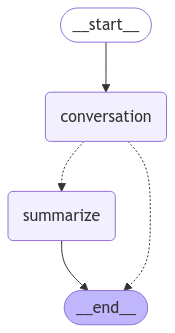

In [93]:
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(State)
builder.add_node("conversation", call_model)
builder.add_node("summarize", summarize_conversation)

builder.add_edge(START, "conversation")
builder.add_conditional_edges("conversation", should_continue)
builder.add_edge("summarize", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

## **Threads**

The checkpointer saves the state at each step as checkpoint.
These saved checkpoints can be grouped into a ```thread``` of conversation.
think about Slack as an analog: different channels carry different conversations.
Below we can usae ```configurable```

In [94]:
#create a thread
config = {"configurable": {"thread_id": "1"}}

#start conversation
input_message = HumanMessage(content="Hi! I am Lance")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what´s my name")
output = graph.invoke({"messages": [input_message]}, config=config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="I like movies")
output = graph.invoke({"messages": [input_message]}, config=config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Nice to meet you, Lance! How can I assist you today?
================================== Ai Message ==================================

Your name is Lance.
================================== Ai Message ==================================

That's great! What kind of movies do you enjoy watching?


In [95]:
graph.get_state(config).values.get('summary', '')

''

In [96]:
input_message = HumanMessage(content="I like history. which period from history do you think that made the most impact in humankind?")
output = graph.invoke({"messages": [input_message]}, config=config)
for m in output['messages'][-1:]:
    m.pretty_print()


================================== Ai Message ==================================

There have been many significant periods in history that have made a great impact on humankind, but one of the most influential periods is often considered to be the Industrial Revolution. This period, which began in the late 18th century and continued into the 19th century, saw a major shift from agrarian societies to industrialized ones, leading to advancements in technology, transportation, and production. The Industrial Revolution had far-reaching effects on society, economics, and culture, shaping the modern world as we know it today.


In [97]:
graph.get_state(config).values.get('summary', '').content

'In our conversation, Lance mentioned his interest in movies and history. He particularly enjoys movies and is interested in learning about the impact of different historical periods on humankind. We discussed the Industrial Revolution as one of the most influential periods in history, leading to advancements in technology and shaping the modern world.'

## **Chatbot with message summarization & external DB memory**

In [100]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:")

#Saved to lacl db
#db_path = "state_db/example.db"
#conn = sqlite3.connect(db_path, check_same_thread=False)